In [1]:
%gui qt6

# Qt6 stuff
from PyQt6.QtWidgets import QApplication
from PyQt6 import QtWidgets
from PyQt6 import QtGui
from PyQt6 import QtCore
from PyQt6.QtCore import pyqtSignal

# Plotting stuff
import pyqtgraph as pg
import matplotlib.pyplot as plt
import cmasher as cmr

# Science stuff
import numpy as np
import pandas as pd
from spectres import spectres

# Astropy stuff
from astropy.io import fits
from astropy.table import Table
import astropy.units as u
from astropy.units.quantity import Quantity
from astropy.io.ascii import read as ascii_read


# General stuff
import logging
import sys
from pathlib import Path
from itertools import cycle

In [2]:
# zHunter stuff
from zhunter import DIRS
from zhunter import io
from zhunter.misc import set_up_linked_vb, get_vb_containing, convert_to_bins
from zhunter.colors import get_gradient
from zhunter.spectroscopic_system import SpecSystemModel, SpecSystem
from zhunter.MainGraphicsWidget import MainGraphicsWidget
from zhunter.data_handler import DataHandler

In [3]:
# astropalmerio stuff
# import astropalmerio.io as io
import astropalmerio.spectra as sp
import astropalmerio.galaxies as gal
import astropalmerio.mc as mc
from astropalmerio.spectra import ergscm2AA
from astropalmerio.spectra import EmissionLine
from specutils import Spectrum1D

In [4]:
from zhunter.colors import COLORS
color_style = 'kraken9'
colors = COLORS[color_style]

In [5]:
log = logging.getLogger(__name__)
logging.basicConfig(stream=sys.stdout, level=logging.DEBUG,
                    format='%(asctime)s %(levelname)s [%(name)s] %(message)s')
logging.getLogger("matplotlib").setLevel(logging.WARNING)
logging.getLogger("PIL").setLevel(logging.WARNING)

In [6]:
# start qt event loop
_instance = QApplication.instance()
if not _instance:
    _instance = QApplication([])
app = _instance

In [7]:
fname = Path('../data/test_input_files/XSHOOTER_esoreflex_2D.fits.gz')


In [8]:
fits.open(fname).info()

Filename: ../data/test_input_files/XSHOOTER_esoreflex_2D.fits.gz
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  FLUX          1 PrimaryHDU     627   (24318, 101)   float64   
  1  ERRS          1 ImageHDU        31   (24318, 101)   float64   
  2  QUAL          1 ImageHDU        30   (24318, 101)   int64   


# How are fits spectra built?
The way the wavelength/spatial arrays is built is by looking in the fits header for the following keywords:

- `CRPIX1`/`CRPIX2` : **reference pixel** (usually = 1)
- `CRVAL1`/`CRVAL2` : reference value at reference pixel (for example 533.66 for wavelength for VIS arm of XShooter). This is the **start** (the minimum) of the array
- `CDELT1`/`CDELT2` (or `CD1_1`/`CD2_2`) : the **step** ($\Delta\lambda$/$\Delta$") to build the array. Typically this is the bin size, or the distance (in physical units of a given axis, e.g. Å for wavelength) between two consecutive pixels on the detector.
- `NAXIS1`/`NAXIS2` : the **number of pixels** in each axis.

Then the array is built as:

```
x = np.arange(number_pixels)
array = ((x - reference_pixel + 1) * step + start)
```

In [9]:
wvlg, spat, flux2D, unc, header = io.read_fits_2D_spectrum(fname)

2023-03-21 18:17:45,873 INFO [zhunter.io] Attempting to read file: ../data/test_input_files/XSHOOTER_esoreflex_2D.fits.gz
2023-03-21 18:17:46,810 WARNING [astropy] UnitsWarning: 'erg/s/cm2/Angstrom' contains multiple slashes, which is discouraged by the FITS standard
2023-03-21 18:17:46,825 DEBUG [zhunter.io] Using the FITS CD matrix.
2023-03-21 18:17:46,826 DEBUG [zhunter.io] PIX=1.0 VAL=-10.58000019073486 DELT=0.159999847412109
2023-03-21 18:17:46,827 DEBUG [zhunter.io] Using the FITS CD matrix.
2023-03-21 18:17:46,828 DEBUG [zhunter.io] PIX=1.0 VAL=533.66 DELT=0.0199999999999818


In [10]:
wvlg.shape, spat.shape, flux2D.shape

((24318,), (101,), (101, 24318))

In [11]:
ypix_max = 10
xpix_max = 25
flux2D_sub = flux2D[:ypix_max,:xpix_max]
wvlg_sub = wvlg[:xpix_max]
spat_sub = spat[:ypix_max]

In [63]:
# # Fake data for testing
# flux2D_sub = np.array(
#     [[1,2,3,2,1],
#     [2,3,4,3,2],
#     [0.5,1.5,2.5,1.5,0.5]]
# ) * u.adu
# wvlg_sub = np.arange(flux2D_sub.shape[1]) * u.nm
# spat_sub = np.arange(flux2D_sub.shape[0]) * u.arcsec
# wvlg_sub, spat_sub, flux2D_sub

(<Quantity [0., 1., 2., 3., 4.] nm>,
 <Quantity [0., 1., 2.] arcsec>,
 <Quantity [[1. , 2. , 3. , 2. , 1. ],
            [2. , 3. , 4. , 3. , 2. ],
            [0.5, 1.5, 2.5, 1.5, 0.5]] adu>)

# How to properly display them?
Ultimately, data taken with CCDs detectors are essentially histograms of counts.
Each pixel is actually a bin, which means that to accurately display the spectra, one has to adjust the wavelength and spatial arrays.

## Displaying in pixels

In [12]:
win = pg.GraphicsLayoutWidget(show=True)
# To suppress qt.pointer.dispatch warning
win.viewport().setAttribute(
            QtCore.Qt.WidgetAttribute.WA_AcceptTouchEvents,
            False,
        )


pi = win.addPlot()

In [13]:
spec_2D = pg.ImageItem()
# Have to use the transpose here for historical reasons
spec_2D.setImage(flux2D_sub.T.value)
pi.addItem(spec_2D)
pi.showGrid(x=True, y=True)

Note that matplotlib's imshow display is different than pyqtgraph's: it centers the value on the pixel, i.e. the point (0,0) is actually at the _center_ of the first pixel (instead of the edge).

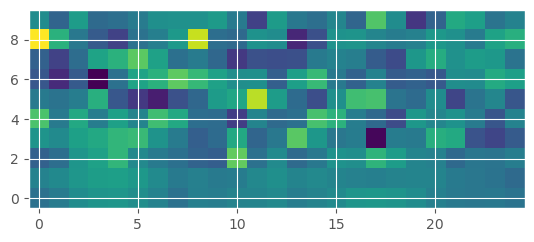

In [14]:
fig, ax = plt.subplots()

ax.imshow(flux2D_sub.value, origin='lower')
plt.show()

## Displaying in physical units
Using `pyqtgraph`, we need to create a rectangle (called `QRectF`) to hold the image, which spans the correct physical space. Because `pyqtgraph` doesn't display pixels in the center but rather at the edge, we need to shift the lower and upper bounds of the rectangle by $\Delta\lambda$/2 and  $\Delta$"/2.

In [15]:
dw = wvlg_sub.value[1] - wvlg_sub.value[0]
ds = spat_sub.value[1] - spat_sub.value[0]
wvlg_span = wvlg_sub.max().value - wvlg_sub.min().value
spatial_span = spat_sub.max().value - spat_sub.min().value

rect = QtCore.QRectF(
    wvlg_sub.min().value - dw/2,   # lower edge of the first wvlg bin
    spat_sub.min().value - ds/2,   # lower edge of the first spatial bin
    wvlg_span + dw,              # x-span of the rectangle
    spatial_span + ds,           # y-span of the rectangle
)
spec_2D.setRect(rect)

In [16]:
# Check that we recover the correct delta lambda
print((wvlg_span + dw)/len(wvlg_sub))
print(header['CD1_1'])

0.01999999999998181
0.0199999999999818


In [17]:
# Or convert directly to bins before making the rectangle
# I find this simpler to understand

def convert_to_bins(array):
    # Modify array to be of size len(array)+1 by adding the right
    # edge of the last bin and shifting everything by step/2.
    # This is to allow for accurate visualization with stepMode='center'
    if isinstance(array, Quantity):
        array_unit = array.unit
    else:
        array_unit = 1
    delta = array[1] - array[0]
    n_bin_edges = len(array) + 1
    bins = np.linspace(array[0]-delta/2, array[-1]+delta/2, n_bin_edges) * array_unit
    return bins

wvlg_bins = convert_to_bins(wvlg_sub)
spat_bins = convert_to_bins(spat_sub)
wvlg_span = wvlg_bins.max().value - wvlg_bins.min().value
spatial_span = spat_bins.max().value - spat_bins.min().value

rect = QtCore.QRectF(
    wvlg_bins.min().value,   # lower edge of the first wvlg bin
    spat_bins.min().value,   # lower edge of the first spatial bin
    wvlg_span,              # x-span of the rectangle
    spatial_span,           # y-span of the rectangle
)
spec_2D.setRect(rect)